In [195]:
from IPython.display import set_matplotlib_formats
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import os

NAX = np.newaxis

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import handlers

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

assert numpyro.__version__.startswith('0.6.0')
#numpyro.set_platform("gpu")

numpyro.set_platform("cpu")
#numpyro.set_host_device_count(5)

from scipy.integrate import simps
from jax.numpy import trapz

In [26]:
cd ..

/mnt/disk2/samarth/qdpy-numpyro


In [27]:
cd qdpy_jax

/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax


In [30]:
run rotation_kernels.py

4.713296890258789e-06
0.00031707191467285155


### Creating a simple qdPy script to test out pyro

In [179]:
def eig_mcmc_func(w1=None, w3=None, w5=None):
    return  get_eigs(create_supermatrix(w1, w3, w5))/2./omega0
    

#def create_supermatrix(wsr_slope):
def create_supermatrix(w1, w3, w5):
    integrand1 = Tsr[0, :] * w1
    integrand3 = Tsr[1, :] * w3
    integrand5 = Tsr[2, :] * w5
    integral1 = trapz(integrand1, x=r)
    integral3 = trapz(integrand3, x=r)
    integral5 = trapz(integrand5, x=r)
    prod_gamma1 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma3 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma5 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    wpi = (wigvals[:, 0]*integral1*prod_gamma1 + 
           wigvals[:, 1]*integral3*prod_gamma3 +
           wigvals[:, 2]*integral5*prod_gamma5)
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*(wigvals @ (prod_gammas * integral))
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*wpi
    diag = 8*np.pi*omega0*wpi
    supmat = jnp.diag(diag)
    return supmat

def get_eigs(mat):
    eigvals, eigvecs = jnp.linalg.eigh(mat)
    return eigvals
"""
    eigbasis_sort_idx = np.zeros(len(eigvals), dtype=np.int16)
    for i in range(len(eigvals)):
        eigbasis_sort_idx[i] = abs(eigvecs[i]).argmax()
    return jnp.asarray(eigvals[eigbasis_sort_idx])
"""

def gamma(ell):
    return jnp.sqrt((2*ell+1)/4./np.pi)

def minus1pow_vecm(num):
    modval = num % 2
    retval = np.zeros_like(modval)
    retval[modval == 1] = -1
    retval[modval == 0] = 1
    return retval

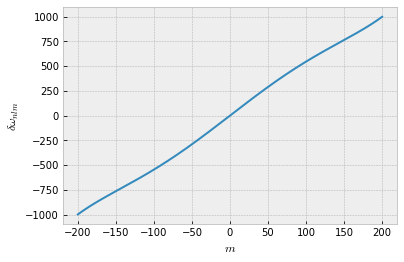

In [191]:
r = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/r.dat')
U = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/U3672.dat')
V = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/V3672.dat')

rmin, rmax = 0.3, 1.0
rmin_idx = np.argmin(abs(r - rmin))
rmax_idx = np.argmin(abs(r - rmax)) + 1

r = r[rmin_idx:rmax_idx]
U = U[rmin_idx:rmax_idx]
V = V[rmin_idx:rmax_idx]

r = jnp.asarray(r)
U = jnp.asarray(U)
V = jnp.asarray(V)
Tsr = jnp.asarray(Tsr)

n1, n2 = 0, 0
ell1, ell2 = 200, 200
ell = min(ell1, ell2)
nu0 = 4741.

Msol = 1.989e33
Rsol = 6.956e10
B0 = 10.e5
OM = jnp.sqrt(4*np.pi*Rsol*B0**2/Msol)
nu0 /= OM*1e6
omega0 = 2*jnp.pi*nu0

s_arr = jnp.array([1., 3., 5.])
m = jnp.arange(-ell, ell+1)
wigvals = np.zeros((2*ell+1, len(s_arr)))
for i in range(len(s_arr)):
    wigvals[:, i] = w3j_vecm(ell1, s_arr[i], ell2, -m, 0*m, m)
    
wigvals = jnp.asarray(wigvals)
w1t, w3t, w5t = 10.51, .43, .175
eigvals_true = get_eigs(create_supermatrix(w1t, w3t, w5t))/2/omega0

plt.figure()
plt.plot(m, eigvals_true)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()



In [192]:
def model():
    w1min, w1max = -2.*abs(w1t), 2.*abs(w1t)
    w3min, w3max = -2.*abs(w3t), 2.*abs(w3t)
    w5min, w5max = -2.*abs(w5t), 2.*abs(w5t)
    
    w1 = numpyro.sample('w1', dist.Uniform(w1min, w1max))
    w3 = numpyro.sample('w3', dist.Uniform(w3min, w3max))
    w5 = numpyro.sample('w5', dist.Uniform(w5min, w5max))
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.1, 10.0))
    #mu = numpyro.deterministic('mu', linear_func(m=m, x=x, b=b, f=1))
    eig_sample = numpyro.deterministic('eig', eig_mcmc_func(w1=w1, w3=w3, w5=w5))
    return numpyro.sample('obs', dist.Normal(eig_sample, sigma), obs=eigvals_true)


In [196]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(12)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=50, num_samples=500)#, num_chains=5)

In [197]:
mcmc.run(rng_key_)
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()

sample: 100%|██████████| 550/550 [01:03<00:00,  8.73it/s, 9 steps of size 6.35e-03. acc. prob=0.17] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      2.68      0.08      2.66      2.64      2.68     21.53      1.05
        w1    -10.51      0.00    -10.51    -10.51    -10.51    289.75      1.01
        w3     -0.43      0.00     -0.43     -0.43     -0.43     25.36      1.00
        w5     -0.17      0.01     -0.18     -0.18     -0.17     93.49      1.00

Number of divergences: 208


IndexError: index 4 is out of bounds for axis 0 with size 4

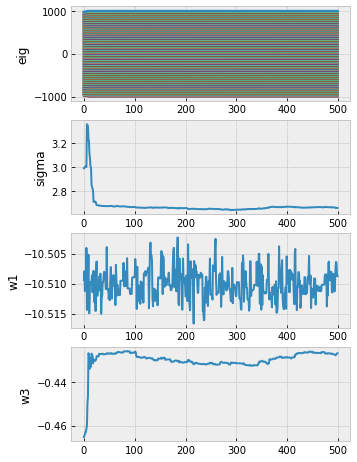

In [199]:
samples_1 = mcmc.get_samples()
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()
#plt.plot(samples_1['m'])

5